# Système d'alerte pour les tempêtes

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from time import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
 
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

##### Pour ce qui est du système d'alerte pour les tempêtes on va cibler fk_arb_etat et plus particulièrement essouché. Nos arbres emporter par une tempête vont être éssouché. Après un arbre emporter par une tempête peut aussi être non essouché en mode cassé.

## Préparation des Données

### importation de la base de donnée

In [2]:
DataFrame = pd.read_csv("Data_Arbre.csv")
print(DataFrame.head())

   longitude   latitude              clc_quartier             clc_secteur  \
0   3.293264  49.840500  Quartier du Centre-Ville             Quai Gayant   
1   3.273380  49.861409    Quartier du Vermandois              Stade Cepy   
2   3.289068  49.844513  Quartier du Centre-Ville   Rue Villebois Mareuil   
3   3.302387  49.861778      Quartier de l'Europe  Square des Marronniers   
4   3.304047  49.858446      Quartier de l'Europe           Avenue Buffon   

   haut_tot  haut_tronc  tronc_diam fk_arb_etat fk_stadedev     fk_port  \
0       6.0         2.0        37.0    EN PLACE       Jeune  semi libre   
1      13.0         1.0       160.0    EN PLACE      Adulte  semi libre   
2      12.0         3.0       116.0    REMPLACÉ      Adulte  semi libre   
3      16.0         3.0       150.0    EN PLACE      Adulte  semi libre   
4       5.0         2.0       170.0    Essouché      Adulte      réduit   

  fk_pied fk_situation fk_revetement  age_estim  fk_prec_estim  clc_nbr_diag  \
0   ga

### Sélection des colonnes pertinentes de la base de données afin de prédire la position des arbres susceptibles d'être déracinés en cas de tempête

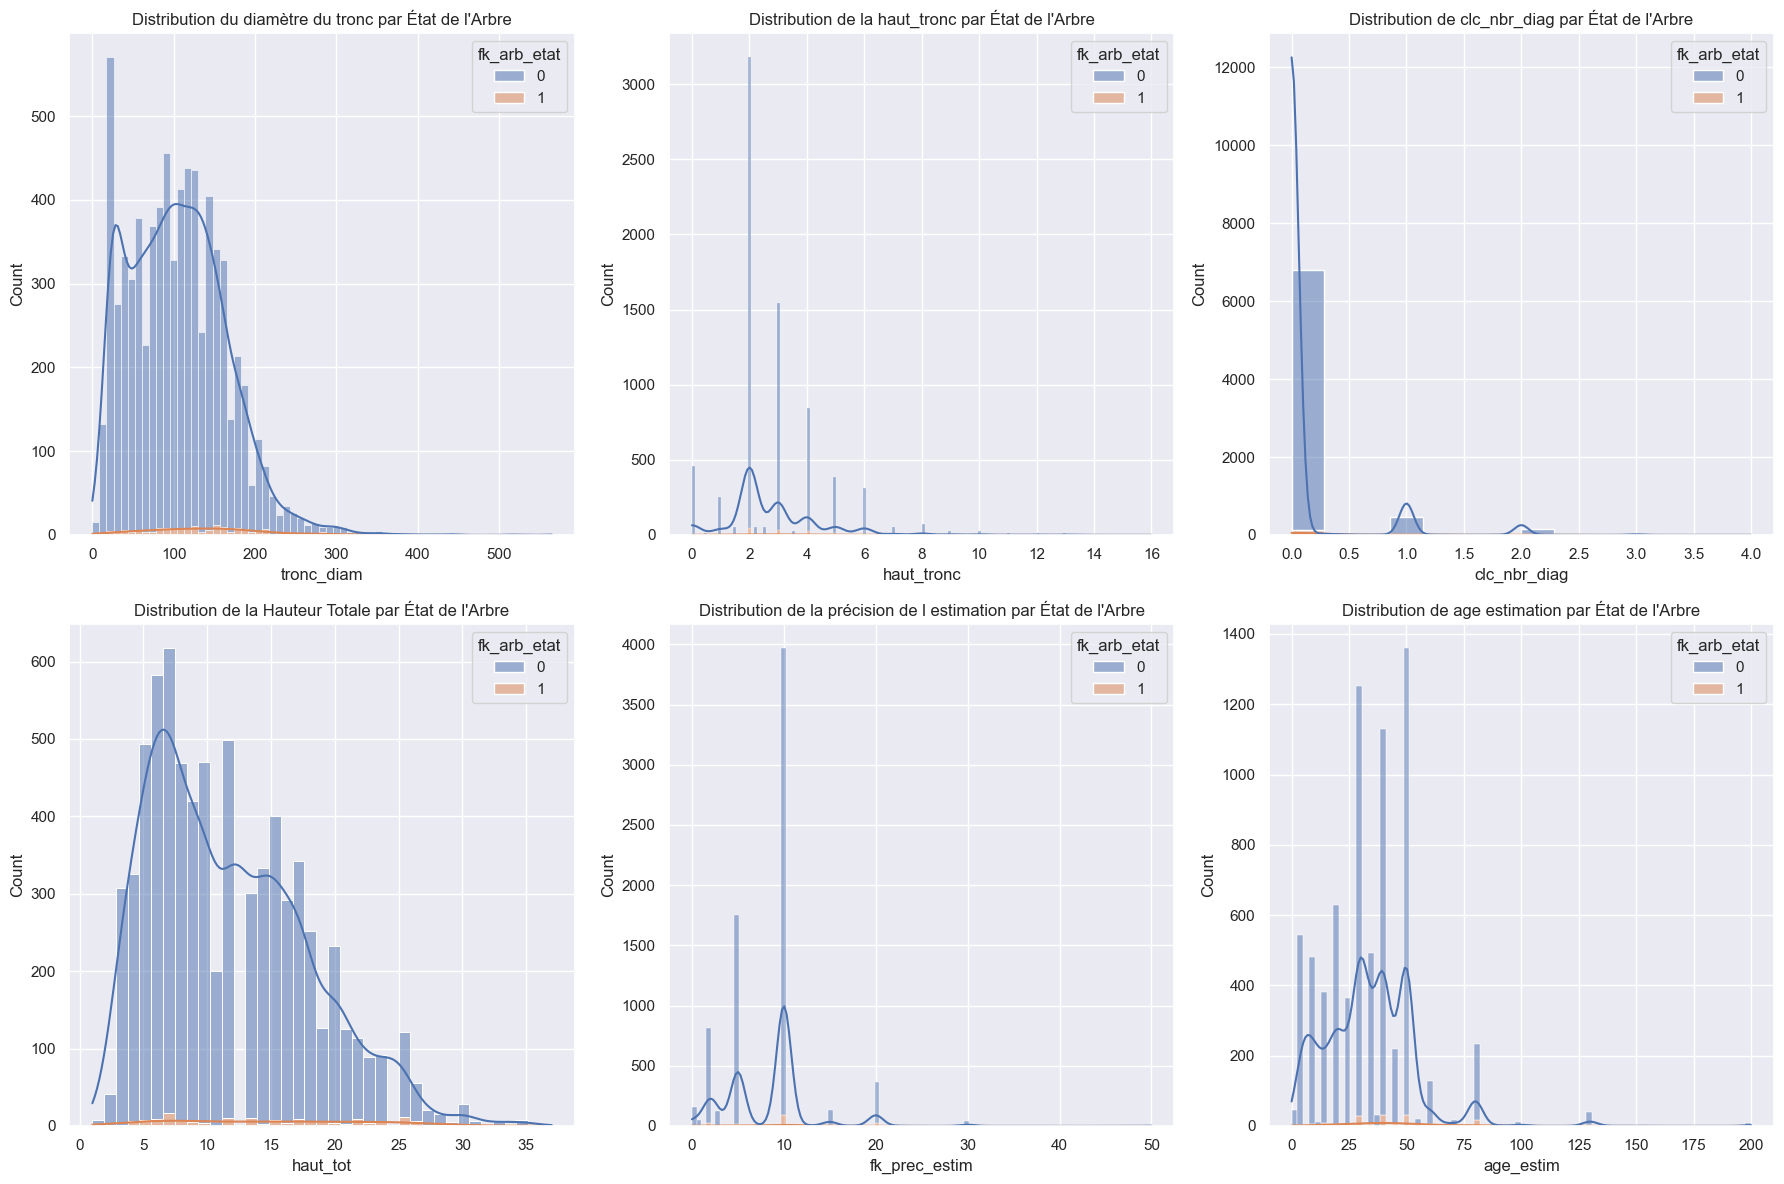

relation entre fk_arb_etat et fk_stadedev
p_valeur : 2.287700814094892e-06 

relation entre fk_arb_etat et fk_port
p_valeur : 0.0003268397537599953 

relation entre fk_arb_etat et fk_pied
p_valeur : 4.3880664790460474e-05 

relation entre fk_arb_etat et fk_situation
p_valeur : 1.7270924721214886e-07 

relation entre fk_arb_etat et fk_revetement
p_valeur : 0.1251796171812398 

relation entre fk_arb_etat et feuillage
p_valeur : 0.52509144001299 

relation entre fk_arb_etat et remarquable
p_valeur : 0.46100362941339823 



In [3]:
#l'encodage de nos données a déjà été effectué dans le fichier "Data_Arbre.csv".
#comment choisir les colonnes pertinentes pour la prédiction de la position des arbres susceptibles d'être déracinés en cas de tempête ?
# les différentes colonnes sont les suivantes : longitude, latitude, clc_quartier, clc_secteur, haut_tot, haut_tronc, tronc_diam, fk_arb_etat, fk_stadedev, fk_port, fk_pied, fk_situation, fk_revetement, age_estim, fk_prec_estim, clc_nbr_diag, fk_nomtech, villeca, feuillage, remarquable

#au début j'ai effectué une matrice de corrlation mais je me suis vite rendu compte que cela n'était pas pertinent pour ce type de données
# j'opte donc pour une méthode différente : les histplot
# conseillé par notre cher ami elouan
# https://seaborn.pydata.org/generated/seaborn.histplot.html
#on aurait egalement pu utiliser displot ou même des boxplots et en fonction de la médiane déterminer si la colonne est pertinente ou non
#https://seaborn.pydata.org/generated/seaborn.displot.html
#l'utilisation d'axe permet de tracer plusieurs graphiques sur une seule figure
#https://stackoverflow.com/questions/63895392/seaborn-is-not-plotting-within-defined-subplots
#un peu comme ce que l'on a fait dans le projet de math


# Sélectionner les colonnes pertinentes
sns.set_theme()
# on étudie les arbres essouchés car ce sont les arbres qui ont été déracinés par la tempête
DataFrame.loc[DataFrame['fk_arb_etat'] == 'Essouché', 'fk_arb_etat'] = 1
DataFrame.loc[DataFrame['fk_arb_etat'] != 1, 'fk_arb_etat'] = 0
DataFrame['fk_arb_etat'] = DataFrame['fk_arb_etat'].astype('int')


colonnes_pertinentes = ['fk_prec_estim', 'haut_tronc', 'haut_tot', 'tronc_diam', 'fk_arb_etat', 'age_estim', 'clc_nbr_diag']
data_pertinent = DataFrame[colonnes_pertinentes]

# Tracer des histogrammes pour les variables numériques en fonction de fk_arb_etat
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
#multiple='stack' permet de superposer les histogrammes
#kde=True permet de tracer la densité de probabilité
#voir la documentation pour plus d'informations
sns.histplot(data=data_pertinent, x='tronc_diam', hue='fk_arb_etat', multiple='stack', ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution du diamètre du tronc par État de l\'Arbre')

sns.histplot(data=data_pertinent, x='haut_tronc', hue='fk_arb_etat', multiple='stack', ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution de la haut_tronc par État de l\'Arbre')

sns.histplot(data=data_pertinent, x='haut_tot', hue='fk_arb_etat', multiple='stack', ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribution de la Hauteur Totale par État de l\'Arbre')

sns.histplot(data=data_pertinent, x='fk_prec_estim', hue='fk_arb_etat', multiple='stack', ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Distribution de la précision de l estimation par État de l\'Arbre')

sns.histplot(data=data_pertinent, x='clc_nbr_diag', hue='fk_arb_etat', multiple='stack', ax=axes[0, 2], kde=True)
axes[0, 2].set_title('Distribution de clc_nbr_diag par État de l\'Arbre')

sns.histplot(data=data_pertinent, x='age_estim', hue='fk_arb_etat', multiple='stack', ax=axes[1, 2], kde=True)
axes[1, 2].set_title('Distribution de age estimation par État de l\'Arbre')

plt.tight_layout()
plt.show()

#pour les variables qualitatives, on va  effectuer le test de chi2 pour voir si elles sont pertinentes pour la prédiction de la position des arbres susceptibles d'être déracinés en cas de tempête
#https://datascientest.com/correlation-entre-variables-comment-mesurer-la-dependance
# Test de chi2 pour les variables qualitatives
table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['fk_stadedev'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et fk_stadedev')
print('p_valeur :', result[1],'\n')

table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['fk_port'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et fk_port')
print('p_valeur :', result[1],'\n')

table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['fk_pied'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et fk_pied')
print('p_valeur :', result[1],'\n')

table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['fk_situation'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et fk_situation')
print('p_valeur :', result[1],'\n')

table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['fk_revetement'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et fk_revetement')
print('p_valeur :', result[1],'\n')

table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['feuillage'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et feuillage')
print('p_valeur :', result[1],'\n')

table = pd.crosstab(DataFrame['fk_arb_etat'], DataFrame['remarquable'])
result = chi2_contingency(table)
print('relation entre fk_arb_etat et remarquable')
print('p_valeur :', result[1],'\n')



In [15]:
# feature selection : on va choisir les colonnes pertinentes pour la prédiction de la position des arbres susceptibles d'être déracinés en cas de tempête
# pour ce qui est de l'encodage, utilisation de One Hot Encoding, comme ce que la professeure a fait nous a conseillé de faire
# One Hot Encoding = https://medium.com/@sii-lille/data-science-one-hot-encoding-c59e82b3f0e7  Le one-hot encoding convertit les variables catégorielles en vecteurs de zéros et de uns, mieux que ce que l'on a fait dans le TP1, si on aurait eu 0, 1, 2 on aurait crée une relation implicite entre les valeurs
#https://scikit-learn.org/stable/modules/feature_selection.html   use 1.13.4
#https://www.geeksforgeeks.org/feature-selection-using-selectfrommodel-and-lassocv-in-scikit-learn/
#utilisation de la doc https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles pour la standardisation des données
#SelectFromModel : grâce à l'utilisation des scores d'importance des fonctionnalités d'un modèle pré-entraîné, la méthode de sélection des fonctionnalités scikit-learn SelectFromModel détermine automatiquement quelles fonctionnalités sont les plus importantes. Après la formation, seules les fonctionnalités qui répondent à un seuil de signification spécifié par l'utilisateur sont conservées par le modèle (soit arborescent, soit linéaire). En plus de maintenir, voire d'améliorer les performances de prédiction, cette stratégie simplifie les modèles en mettant l'accent sur les aspects les plus informatifs, en encourageant l'efficacité et en améliorant l'interprétabilité.


# Séparation des variables indépendantes et dépendantes 
#on ne prend pas en compte la colonne "fk_arb_etat" car c'est la colonne qu'on veut prédire
colonnes_numeriques = ['longitude', 'latitude', 'haut_tot', 'haut_tronc', 'tronc_diam', 'age_estim', 'fk_prec_estim', 'clc_nbr_diag']
colonnes_categorieles = ['clc_quartier', 'clc_secteur', 'fk_stadedev', 'fk_port', 'fk_pied', 'fk_situation', 'fk_revetement', 'fk_nomtech', 'feuillage', 'villeca']
DataFrame.loc[DataFrame['remarquable'] == 'Oui', 'remarquable'] = 1
DataFrame.loc[DataFrame['remarquable'] != 1, 'remarquable'] = 0
DataFrame['remarquable'] = DataFrame['remarquable'].astype('int')



# Encodage des variables catégorielles
#one hot encoding
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
# Utilisons la méthode 'get_dummies' de pandas pour effectuer le one-hot encoding
# Concaténons les colonnes numériques avec les données 'countries' encodées en one-hot
#aller voir la doc pour plus d'informations très bien expliqué
X = pd.concat([DataFrame[colonnes_numeriques], pd.get_dummies(DataFrame[colonnes_categorieles]), DataFrame['remarquable']], axis=1)
y = DataFrame['fk_arb_etat']

# # Standardisation des données
# # on met nos données à la même échelle
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
       
# # Affichage des données standardisées
# # Conversion en DataFrame pour un affichage lisible
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

#SMOTE : Synthetic Minority Over-sampling Technique
# sert à équilibrer les classes en créant des échantillons synthétiques de la classe minoritaire
#https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
smote = SMOTE(random_state=42, sampling_strategy=0.2)
X_train_smote, y_train_smote = smote.fit_resample(X_scaled, y)

#Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_train_smote, y_train_smote, test_size=0.3, random_state=42)

# Entraînement du modèle RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#Importance des caractéristiques
importance = clf.feature_importances_
indices = np.argsort(importance)[::-1]
print("\nImportance des caractéristiques :")
for f in range(X_train.shape[1]):
    print(f"{X.columns[indices[f]]} : {importance[indices[f]]}")






Importance des caractéristiques :
haut_tronc : 0.07474606544587638
age_estim : 0.06226475860404117
longitude : 0.05636444612148468
fk_prec_estim : 0.05508508428610531
latitude : 0.053482097678084234
clc_nbr_diag : 0.04950820787084634
haut_tot : 0.04315370471442272
fk_situation_Groupe : 0.04296090858890086
tronc_diam : 0.04020463555784501
fk_situation_Alignement : 0.034433364773691265
clc_quartier_Quartier Remicourt : 0.026970142989167008
clc_secteur_Parc des Champs-Elysées : 0.021363642144090977
fk_situation_Isolé : 0.019840826132772278
clc_secteur_Cimetière Sud : 0.018366818753087058
fk_pied_gazon : 0.01686327942179091
fk_pied_Terre : 0.016171480476385523
fk_port_semi libre : 0.013817165380417037
fk_nomtech_SORAUC : 0.013475567196720552
fk_nomtech_BETPEN : 0.012244138251870823
fk_stadedev_Adulte : 0.011468941876101686
fk_nomtech_PLAACE : 0.011128807783840974
feuillage_Conifère : 0.01065022977488533
feuillage_Feuillu : 0.010394465413887477
fk_nomtech_TILCOR : 0.009696314910946684
fk_n

| Variable      | Description                                    | Pertinence                                                                                               |
|---------------|------------------------------------------------|----------------------------------------------------------------------------------------------------------|
| haut_tot      | Hauteur totale de l'arbre                      | La hauteur de l'arbre peut déterminer la susceptibilité de l'arbre à être déraciné en cas de tempête     |
| tronc_diam    | Diamètre du tronc de l'arbre                   | Indique la robustesse de l'arbre, il peut être déraciné s'il a un petit diamètre                         |
| haut_tronc    | Hauteur du tronc de l'arbre                    | La hauteur du tronc peut affecter la stabilité de l'arbre, influençant sa susceptibilité à être déraciné |
| age_estim     | Estimation de l'âge de l'arbre                 | L'âge de l'arbre peut influencer sa structure et sa résistance aux tempêtes                              |
| longitude     | Longitude de la position de l'arbre            | La position géographique de l'arbre peut influencer son exposition aux vents violents                    |
| latitude      | Latitude de la position de l'arbre             | La position géographique de l'arbre peut influencer son exposition aux vents violents                    |



In [16]:
# Utiliser les caractéristiques les plus importantes pour entraîner un nouveau modèle
X_train_selected = X_train[:, indices[:20]]
clf_selected = RandomForestClassifier(random_state=42)
clf_selected.fit(X_train_selected, y_train)
X_test_selected = X_test[:, indices[:20]]

# Prédiction
y_pred = clf_selected.predict(X_test_selected)

# Évaluation du modèle
print("\nAccuracy : ", accuracy_score(y_test, y_pred))
print("\nClassification Report :")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix :")
print(confusion_matrix(y_test, y_pred, normalize='true'))
print("\naccuracy Score :")
print(accuracy_score(y_test, y_pred))




Accuracy :  0.9819785276073619

Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2179
           1       0.97      0.92      0.94       429

    accuracy                           0.98      2608
   macro avg       0.98      0.96      0.97      2608
weighted avg       0.98      0.98      0.98      2608


Confusion Matrix :
[[0.99357503 0.00642497]
 [0.07692308 0.92307692]]

accuracy Score :
0.9819785276073619


### Sur quel modèle d'algorithme s'entrainer et pourquoi ?

#### Pour la classification, il nous est demandé d'utiliser l'Apprentissage Supervisé. 

In [ ]:
#dans la famille de l'apprentissage supervisé, on retrouve beaucoup d'algorithmes de classification
#https://scikit-learn.org/stable/supervised_learning.html#supervised-learning
## un algorithme : un ensemble d’opérations suivies dans un ordre précis afin de résoudre un problème ou d’apporter de nouvelles solutions (dans notre cas, la classification, c'est à dire prédire la position des arbres susceptibles d'être déracinés en cas de tempête) via essouché ou non essouché
# quel est le meilleur algorithme de classification pour ce type de données ?
#La sélection de l'algorithme approprié dépend des caractéristiques des données, du type de problème à résoudre, ainsi que des ressources de calcul et de stockage disponibles. Dans notre cas, nous devons prédire la position des arbres susceptibles d'être déracinés en cas de tempête.

# Différentes familles d'algorithmes de classification :
# Algorithmes linéaires
# Algorithmes basés sur les arbres de décision
# Factorisation de matrices
# Méta-algorithmes
# PCA
# Réseaux de neurones



# Analysons les différentes familles et regardons les algorithmes les plus pertinents pour notre problème (Classification binaire)
# En s'aidant de la doc https://learn.microsoft.com/fr-fr/dotnet/machine-learning/how-to-choose-an-ml-net-algorithm et
# aide : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
# On en déduit qu'on peut utiliser les algorithmes suivants :
#  SVC
#  Ridge Regression
#  Logistic Regression
#  SVM
#  GamBinaryTrainer
#  reseau de neuronne
#  random forest classifier


#j'aimerais obtenir une quantité plus importante de vrai positifs et de vrai négatifs





#### Test des différents algorithmes

##### Random Forest :